## Identificar se a imagem Carregada é de um veículo.


In [1]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline

import json
import pickle as pk
from sklearn.metrics import classification_report, confusion_matrix
import cv2

In [2]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.utils.data_utils import get_file
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

Using TensorFlow backend.


In [3]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

In [4]:
#Keras GitHub  
def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [5]:
vgg16 = VGG16(weights='imagenet')
vgg16.save('models/vgg16.h5')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
resnet50 = ResNet50(weights='imagenet')
resnet50.save('models/resnet50.h5')

In [7]:
vgg19 = VGG19(weights='imagenet')
vgg19.save('models/vgg19.h5')

In [15]:
carsImageList = os.listdir('CarImages/Cars')
nonCarsImageList = os.listdir('CarImages/Non_Cars')

In [9]:
def prepare_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

## Testando se a Imagem é de um Veículo com VGG16, VGG19, Resnet

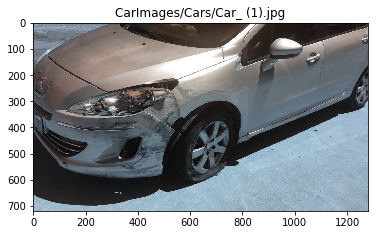

VGG16 Car_ (1).jpg: [[('n03770679', 'minivan', 0.44915715), ('n03100240', 'convertible', 0.19698101), ('n02814533', 'beach_wagon', 0.07700231)]]
ResnetCar_ (1).jpg: [[('n03770679', 'minivan', 0.80797017), ('n02814533', 'beach_wagon', 0.048134446), ('n03459775', 'grille', 0.042126108)]]
VGG19 Car_ (1).jpg: [[('n03770679', 'minivan', 0.6132889), ('n03594945', 'jeep', 0.07906567), ('n02814533', 'beach_wagon', 0.060981315)]]
------------------


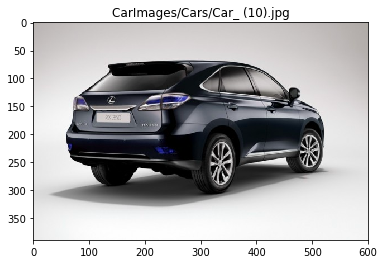

VGG16 Car_ (10).jpg: [[('n03100240', 'convertible', 0.42502502), ('n02814533', 'beach_wagon', 0.17708895), ('n04285008', 'sports_car', 0.14187518)]]
ResnetCar_ (10).jpg: [[('n03770679', 'minivan', 0.3278977), ('n02814533', 'beach_wagon', 0.3126352), ('n02974003', 'car_wheel', 0.11854632)]]
VGG19 Car_ (10).jpg: [[('n03100240', 'convertible', 0.59505165), ('n04285008', 'sports_car', 0.22642419), ('n02974003', 'car_wheel', 0.05818155)]]
------------------


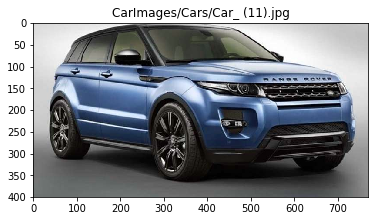

VGG16 Car_ (11).jpg: [[('n04285008', 'sports_car', 0.29797605), ('n02814533', 'beach_wagon', 0.23168717), ('n03459775', 'grille', 0.1281733)]]
ResnetCar_ (11).jpg: [[('n03594945', 'jeep', 0.50626606), ('n03930630', 'pickup', 0.14924264), ('n03459775', 'grille', 0.096210904)]]
VGG19 Car_ (11).jpg: [[('n03930630', 'pickup', 0.2522568), ('n03594945', 'jeep', 0.18400793), ('n02974003', 'car_wheel', 0.14504221)]]
------------------


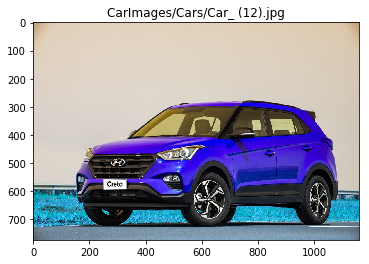

VGG16 Car_ (12).jpg: [[('n03930630', 'pickup', 0.29898396), ('n02974003', 'car_wheel', 0.18218783), ('n04037443', 'racer', 0.12154533)]]
ResnetCar_ (12).jpg: [[('n03930630', 'pickup', 0.34755617), ('n02974003', 'car_wheel', 0.19970904), ('n03770679', 'minivan', 0.16096517)]]
VGG19 Car_ (12).jpg: [[('n03770679', 'minivan', 0.51884186), ('n03930630', 'pickup', 0.14094757), ('n02974003', 'car_wheel', 0.10333484)]]
------------------


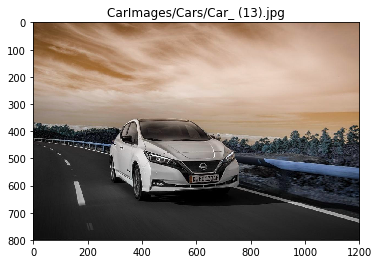

VGG16 Car_ (13).jpg: [[('n04467665', 'trailer_truck', 0.2706574), ('n04037443', 'racer', 0.15481523), ('n03670208', 'limousine', 0.08718545)]]
ResnetCar_ (13).jpg: [[('n04467665', 'trailer_truck', 0.7015737), ('n03770679', 'minivan', 0.21844955), ('n04065272', 'recreational_vehicle', 0.017000096)]]
VGG19 Car_ (13).jpg: [[('n04467665', 'trailer_truck', 0.47752967), ('n02965783', 'car_mirror', 0.19448346), ('n03670208', 'limousine', 0.08751238)]]
------------------


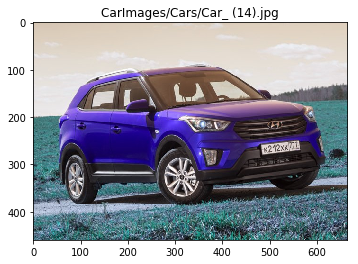

VGG16 Car_ (14).jpg: [[('n03770679', 'minivan', 0.38074762), ('n03930630', 'pickup', 0.1967237), ('n03594945', 'jeep', 0.16850293)]]
ResnetCar_ (14).jpg: [[('n03930630', 'pickup', 0.38358957), ('n02974003', 'car_wheel', 0.13527802), ('n03594945', 'jeep', 0.11469657)]]
VGG19 Car_ (14).jpg: [[('n03770679', 'minivan', 0.33803067), ('n03594945', 'jeep', 0.2324922), ('n03930630', 'pickup', 0.12850524)]]
------------------


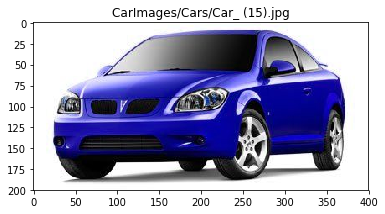

VGG16 Car_ (15).jpg: [[('n03930630', 'pickup', 0.7613261), ('n02814533', 'beach_wagon', 0.0511009), ('n03459775', 'grille', 0.041050155)]]
ResnetCar_ (15).jpg: [[('n03930630', 'pickup', 0.3795909), ('n03459775', 'grille', 0.18359213), ('n02974003', 'car_wheel', 0.14918676)]]
VGG19 Car_ (15).jpg: [[('n03930630', 'pickup', 0.25918308), ('n02814533', 'beach_wagon', 0.1286875), ('n03459775', 'grille', 0.07672529)]]
------------------


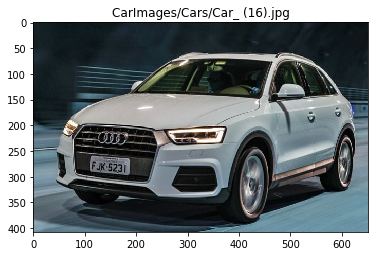

VGG16 Car_ (16).jpg: [[('n04037443', 'racer', 0.21959297), ('n02814533', 'beach_wagon', 0.16154876), ('n04285008', 'sports_car', 0.15995882)]]
ResnetCar_ (16).jpg: [[('n03930630', 'pickup', 0.36064342), ('n03459775', 'grille', 0.13517268), ('n04037443', 'racer', 0.108631395)]]
VGG19 Car_ (16).jpg: [[('n04037443', 'racer', 0.30015582), ('n03930630', 'pickup', 0.17719415), ('n02814533', 'beach_wagon', 0.12042314)]]
------------------


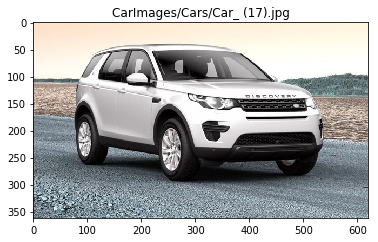

VGG16 Car_ (17).jpg: [[('n03930630', 'pickup', 0.5410373), ('n03770679', 'minivan', 0.13266), ('n02974003', 'car_wheel', 0.052004583)]]
ResnetCar_ (17).jpg: [[('n03930630', 'pickup', 0.58379436), ('n03594945', 'jeep', 0.1392525), ('n03770679', 'minivan', 0.088986136)]]
VGG19 Car_ (17).jpg: [[('n03770679', 'minivan', 0.2862706), ('n03930630', 'pickup', 0.15938373), ('n02814533', 'beach_wagon', 0.11468162)]]
------------------


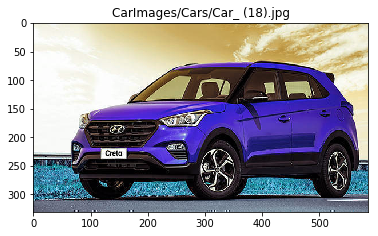

VGG16 Car_ (18).jpg: [[('n03594945', 'jeep', 0.31712246), ('n03930630', 'pickup', 0.21332382), ('n03770679', 'minivan', 0.1789877)]]
ResnetCar_ (18).jpg: [[('n03770679', 'minivan', 0.3744133), ('n03930630', 'pickup', 0.24508652), ('n03459775', 'grille', 0.08980205)]]
VGG19 Car_ (18).jpg: [[('n03594945', 'jeep', 0.49389216), ('n03770679', 'minivan', 0.25956735), ('n03930630', 'pickup', 0.12512918)]]
------------------


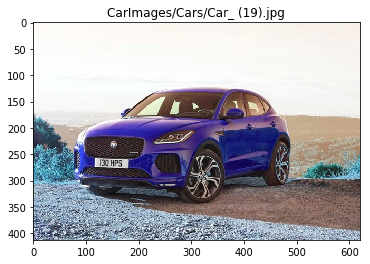

VGG16 Car_ (19).jpg: [[('n03930630', 'pickup', 0.289774), ('n02974003', 'car_wheel', 0.17666292), ('n04285008', 'sports_car', 0.15496956)]]
ResnetCar_ (19).jpg: [[('n02974003', 'car_wheel', 0.2500359), ('n03930630', 'pickup', 0.20487228), ('n03459775', 'grille', 0.15466666)]]
VGG19 Car_ (19).jpg: [[('n04285008', 'sports_car', 0.2959448), ('n03930630', 'pickup', 0.18091571), ('n04037443', 'racer', 0.15699907)]]
------------------


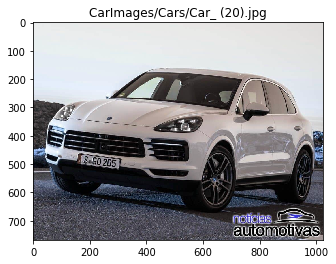

VGG16 Car_ (20).jpg: [[('n04037443', 'racer', 0.42606288), ('n04285008', 'sports_car', 0.2568247), ('n02814533', 'beach_wagon', 0.07040561)]]
ResnetCar_ (20).jpg: [[('n04285008', 'sports_car', 0.31829795), ('n03459775', 'grille', 0.1936346), ('n02974003', 'car_wheel', 0.113427386)]]
VGG19 Car_ (20).jpg: [[('n04037443', 'racer', 0.34859893), ('n04285008', 'sports_car', 0.24449976), ('n02974003', 'car_wheel', 0.120352)]]
------------------


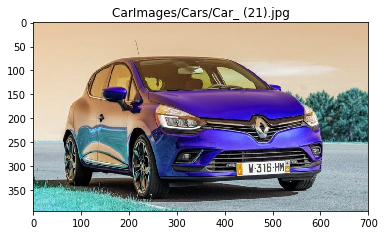

VGG16 Car_ (21).jpg: [[('n03770679', 'minivan', 0.4911855), ('n02814533', 'beach_wagon', 0.1574705), ('n03459775', 'grille', 0.10150425)]]
ResnetCar_ (21).jpg: [[('n03459775', 'grille', 0.23736526), ('n02814533', 'beach_wagon', 0.18199061), ('n02974003', 'car_wheel', 0.16062438)]]
VGG19 Car_ (21).jpg: [[('n04285008', 'sports_car', 0.18061437), ('n03770679', 'minivan', 0.14811437), ('n03459775', 'grille', 0.1284253)]]
------------------


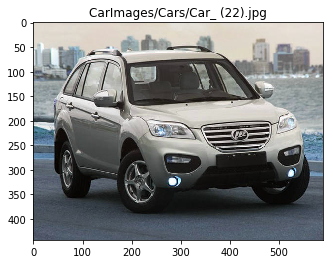

VGG16 Car_ (22).jpg: [[('n03930630', 'pickup', 0.6345017), ('n04461696', 'tow_truck', 0.048954118), ('n02930766', 'cab', 0.038716886)]]
ResnetCar_ (22).jpg: [[('n03930630', 'pickup', 0.4436976), ('n03770679', 'minivan', 0.11926981), ('n04461696', 'tow_truck', 0.08163513)]]
VGG19 Car_ (22).jpg: [[('n03770679', 'minivan', 0.17995709), ('n03930630', 'pickup', 0.15869984), ('n03594945', 'jeep', 0.15669596)]]
------------------


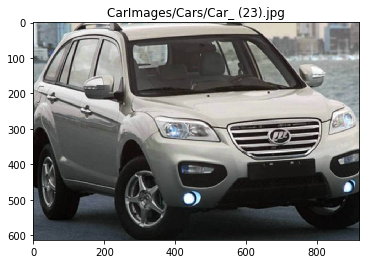

VGG16 Car_ (23).jpg: [[('n03930630', 'pickup', 0.556021), ('n03769881', 'minibus', 0.07511414), ('n04461696', 'tow_truck', 0.062111817)]]
ResnetCar_ (23).jpg: [[('n03769881', 'minibus', 0.30793548), ('n03930630', 'pickup', 0.23860377), ('n03594945', 'jeep', 0.10792978)]]
VGG19 Car_ (23).jpg: [[('n03930630', 'pickup', 0.1908396), ('n03594945', 'jeep', 0.089153126), ('n02930766', 'cab', 0.089094736)]]
------------------


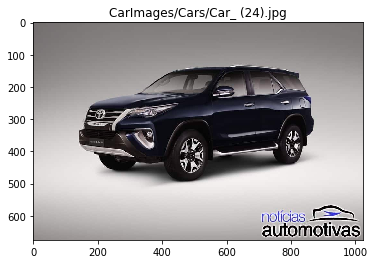

VGG16 Car_ (24).jpg: [[('n03770679', 'minivan', 0.32902545), ('n02814533', 'beach_wagon', 0.25357652), ('n02974003', 'car_wheel', 0.09406818)]]
ResnetCar_ (24).jpg: [[('n03594945', 'jeep', 0.7311014), ('n03930630', 'pickup', 0.15542994), ('n02814533', 'beach_wagon', 0.050161127)]]
VGG19 Car_ (24).jpg: [[('n02974003', 'car_wheel', 0.16685985), ('n04037443', 'racer', 0.13403615), ('n03770679', 'minivan', 0.13310233)]]
------------------


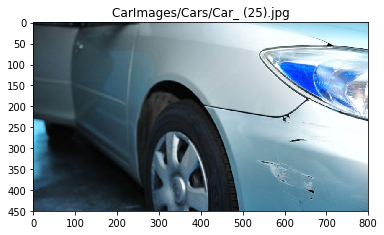

VGG16 Car_ (25).jpg: [[('n04285008', 'sports_car', 0.23933583), ('n03770679', 'minivan', 0.22350632), ('n02974003', 'car_wheel', 0.0970688)]]
ResnetCar_ (25).jpg: [[('n03770679', 'minivan', 0.7820404), ('n03769881', 'minibus', 0.05279188), ('n03670208', 'limousine', 0.014040855)]]
VGG19 Car_ (25).jpg: [[('n03770679', 'minivan', 0.70972425), ('n03670208', 'limousine', 0.04478034), ('n03100240', 'convertible', 0.03794783)]]
------------------


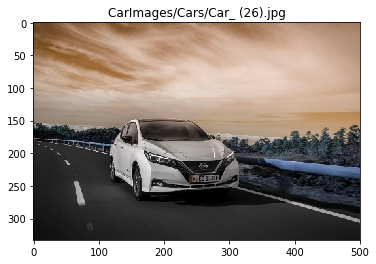

VGG16 Car_ (26).jpg: [[('n04467665', 'trailer_truck', 0.22749172), ('n04037443', 'racer', 0.16840145), ('n03770679', 'minivan', 0.07143028)]]
ResnetCar_ (26).jpg: [[('n04467665', 'trailer_truck', 0.4636398), ('n03770679', 'minivan', 0.3380616), ('n03796401', 'moving_van', 0.06661292)]]
VGG19 Car_ (26).jpg: [[('n04467665', 'trailer_truck', 0.6690544), ('n04266014', 'space_shuttle', 0.06086371), ('n02965783', 'car_mirror', 0.05753658)]]
------------------


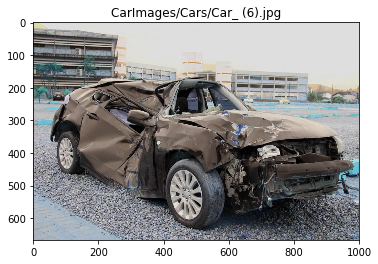

VGG16 Car_ (6).jpg: [[('n03930630', 'pickup', 0.13521397), ('n02974003', 'car_wheel', 0.11057729), ('n04461696', 'tow_truck', 0.1041484)]]
ResnetCar_ (6).jpg: [[('n02769748', 'backpack', 0.17808965), ('n03478589', 'half_track', 0.07935048), ('n04467665', 'trailer_truck', 0.07668403)]]
VGG19 Car_ (6).jpg: [[('n03478589', 'half_track', 0.29090124), ('n04461696', 'tow_truck', 0.1509753), ('n03594945', 'jeep', 0.13016759)]]
------------------


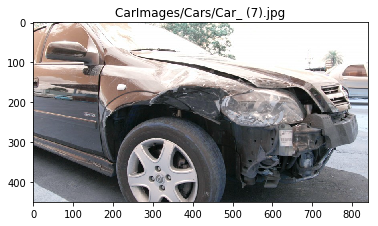

VGG16 Car_ (7).jpg: [[('n04461696', 'tow_truck', 0.29681695), ('n03670208', 'limousine', 0.20789628), ('n03930630', 'pickup', 0.119916424)]]
ResnetCar_ (7).jpg: [[('n03594945', 'jeep', 0.1821003), ('n03770679', 'minivan', 0.15744655), ('n02974003', 'car_wheel', 0.13426863)]]
VGG19 Car_ (7).jpg: [[('n03478589', 'half_track', 0.35256588), ('n03594945', 'jeep', 0.30101764), ('n03670208', 'limousine', 0.18237874)]]
------------------


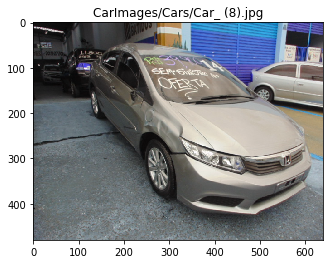

VGG16 Car_ (8).jpg: [[('n03770679', 'minivan', 0.6291864), ('n04285008', 'sports_car', 0.0599966), ('n03100240', 'convertible', 0.05050727)]]
ResnetCar_ (8).jpg: [[('n03770679', 'minivan', 0.7103), ('n03670208', 'limousine', 0.05678962), ('n02814533', 'beach_wagon', 0.035931446)]]
VGG19 Car_ (8).jpg: [[('n03770679', 'minivan', 0.43897098), ('n03100240', 'convertible', 0.11657382), ('n02814533', 'beach_wagon', 0.08786858)]]
------------------


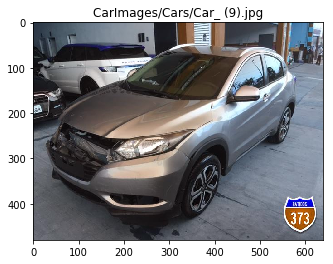

VGG16 Car_ (9).jpg: [[('n04285008', 'sports_car', 0.7466916), ('n03100240', 'convertible', 0.12022396), ('n04037443', 'racer', 0.0270898)]]
ResnetCar_ (9).jpg: [[('n03770679', 'minivan', 0.43761206), ('n04285008', 'sports_car', 0.26733497), ('n03100240', 'convertible', 0.06670843)]]
VGG19 Car_ (9).jpg: [[('n04285008', 'sports_car', 0.37583575), ('n03670208', 'limousine', 0.15171039), ('n02814533', 'beach_wagon', 0.10938445)]]
------------------


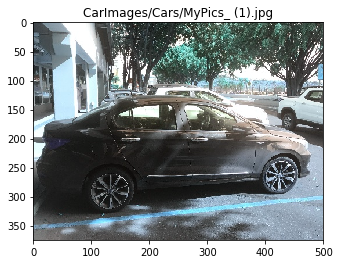

VGG16 MyPics_ (1).jpg: [[('n03100240', 'convertible', 0.36758083), ('n04285008', 'sports_car', 0.1433668), ('n04037443', 'racer', 0.11080567)]]
ResnetMyPics_ (1).jpg: [[('n03100240', 'convertible', 0.24117304), ('n03770679', 'minivan', 0.23927568), ('n02974003', 'car_wheel', 0.16656427)]]
VGG19 MyPics_ (1).jpg: [[('n03100240', 'convertible', 0.29035577), ('n02814533', 'beach_wagon', 0.17050149), ('n03770679', 'minivan', 0.109256424)]]
------------------


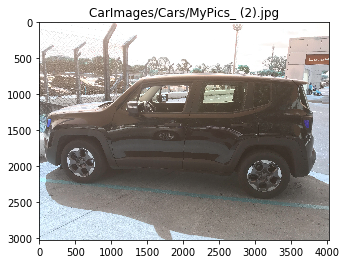

VGG16 MyPics_ (2).jpg: [[('n03930630', 'pickup', 0.6714106), ('n04461696', 'tow_truck', 0.08379441), ('n04252225', 'snowplow', 0.06824128)]]
ResnetMyPics_ (2).jpg: [[('n03594945', 'jeep', 0.29558378), ('n03930630', 'pickup', 0.28467494), ('n03770679', 'minivan', 0.13881029)]]
VGG19 MyPics_ (2).jpg: [[('n03930630', 'pickup', 0.3466433), ('n03594945', 'jeep', 0.18997784), ('n03770679', 'minivan', 0.13941397)]]
------------------


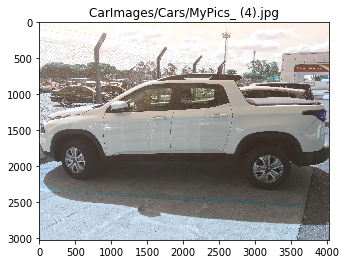

VGG16 MyPics_ (4).jpg: [[('n03930630', 'pickup', 0.79976606), ('n03594945', 'jeep', 0.14095737), ('n04461696', 'tow_truck', 0.020582624)]]
ResnetMyPics_ (4).jpg: [[('n03930630', 'pickup', 0.2990812), ('n02814533', 'beach_wagon', 0.25218114), ('n03594945', 'jeep', 0.2200908)]]
VGG19 MyPics_ (4).jpg: [[('n03930630', 'pickup', 0.53855747), ('n03594945', 'jeep', 0.27776444), ('n04461696', 'tow_truck', 0.051935583)]]
------------------


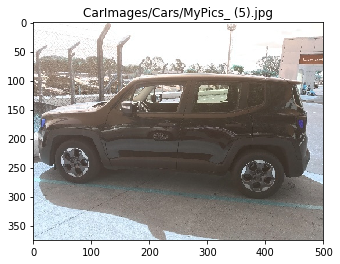

VGG16 MyPics_ (5).jpg: [[('n03930630', 'pickup', 0.7335333), ('n04461696', 'tow_truck', 0.07974044), ('n04252225', 'snowplow', 0.063391)]]
ResnetMyPics_ (5).jpg: [[('n03930630', 'pickup', 0.3499353), ('n03770679', 'minivan', 0.18581733), ('n03594945', 'jeep', 0.13460466)]]
VGG19 MyPics_ (5).jpg: [[('n03930630', 'pickup', 0.35071734), ('n04461696', 'tow_truck', 0.2003829), ('n03770679', 'minivan', 0.10699967)]]
------------------


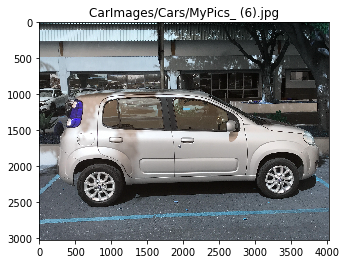

VGG16 MyPics_ (6).jpg: [[('n03770679', 'minivan', 0.3299299), ('n03930630', 'pickup', 0.25899407), ('n04461696', 'tow_truck', 0.07125939)]]
ResnetMyPics_ (6).jpg: [[('n03770679', 'minivan', 0.9325597), ('n03796401', 'moving_van', 0.007692983), ('n03930630', 'pickup', 0.0072734808)]]
VGG19 MyPics_ (6).jpg: [[('n03770679', 'minivan', 0.8654499), ('n03930630', 'pickup', 0.015843801), ('n04461696', 'tow_truck', 0.0149923)]]
------------------


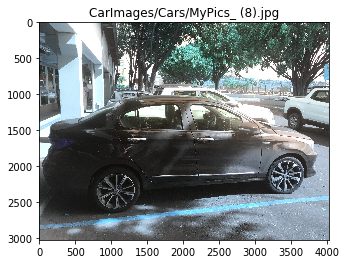

VGG16 MyPics_ (8).jpg: [[('n03100240', 'convertible', 0.49552712), ('n04285008', 'sports_car', 0.17988785), ('n04037443', 'racer', 0.11730447)]]
ResnetMyPics_ (8).jpg: [[('n03770679', 'minivan', 0.28273278), ('n02974003', 'car_wheel', 0.18242104), ('n03459775', 'grille', 0.14916585)]]
VGG19 MyPics_ (8).jpg: [[('n03100240', 'convertible', 0.2834521), ('n02814533', 'beach_wagon', 0.17562568), ('n03770679', 'minivan', 0.1345719)]]
------------------


In [10]:
for eachCar in carsImageList:
    image_path = 'CarImages/Cars/{}'.format(eachCar)
    image = prepare_image(image_path)
    
    imageView = cv2.imread(image_path)
    plt.imshow(imageView)
    plt.title(image_path)
    plt.show()
    
    predictions = vgg16.predict(image)
    print('VGG16 {}: {}'.format(eachCar,get_predictions(predictions, top=3)))
    predictions = resnet50.predict(image)
    print('Resnet{}: {}'.format(eachCar,get_predictions(predictions, top=3)))
    predictions = vgg19.predict(image)
    print('VGG19 {}: {}'.format(eachCar,get_predictions(predictions, top=3)))
    print('------------------')

CarImages/Non_Cars/Bicicleta_ (1).jpg


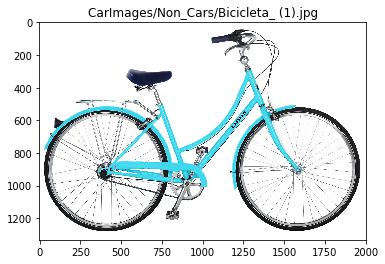

VGG16 Bicicleta_ (1).jpg: [[('n03792782', 'mountain_bike', 0.69118977), ('n02835271', 'bicycle-built-for-two', 0.27863437), ('n04482393', 'tricycle', 0.008700405)]]
ResnetBicicleta_ (1).jpg: [[('n03792782', 'mountain_bike', 0.80529004), ('n02835271', 'bicycle-built-for-two', 0.104276635), ('n04482393', 'tricycle', 0.037655763)]]
VGG19 Bicicleta_ (1).jpg: [[('n02835271', 'bicycle-built-for-two', 0.44333848), ('n04482393', 'tricycle', 0.29675454), ('n03792782', 'mountain_bike', 0.2105941)]]
------------------
CarImages/Non_Cars/Bicicleta_ (2).jpg


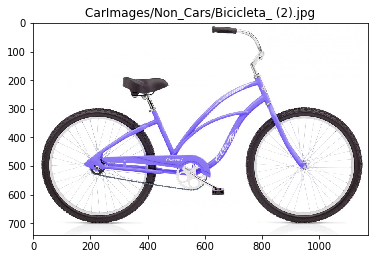

VGG16 Bicicleta_ (2).jpg: [[('n03792782', 'mountain_bike', 0.41118836), ('n04482393', 'tricycle', 0.2840688), ('n02835271', 'bicycle-built-for-two', 0.04848299)]]
ResnetBicicleta_ (2).jpg: [[('n03792782', 'mountain_bike', 0.6450684), ('n04482393', 'tricycle', 0.13517076), ('n02835271', 'bicycle-built-for-two', 0.106159285)]]
VGG19 Bicicleta_ (2).jpg: [[('n04482393', 'tricycle', 0.67404485), ('n03792782', 'mountain_bike', 0.21555811), ('n02835271', 'bicycle-built-for-two', 0.029601656)]]
------------------
CarImages/Non_Cars/Cao_(1).jpg


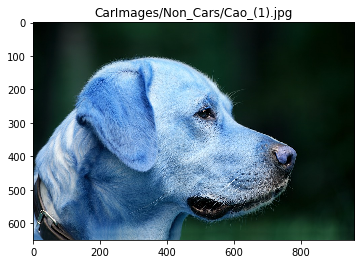

VGG16 Cao_(1).jpg: [[('n02099712', 'Labrador_retriever', 0.5122197), ('n02099601', 'golden_retriever', 0.121747114), ('n02087394', 'Rhodesian_ridgeback', 0.11685928)]]
ResnetCao_(1).jpg: [[('n02087394', 'Rhodesian_ridgeback', 0.85323536), ('n02099712', 'Labrador_retriever', 0.07836163), ('n02100583', 'vizsla', 0.015381717)]]
VGG19 Cao_(1).jpg: [[('n02099712', 'Labrador_retriever', 0.48138443), ('n02087394', 'Rhodesian_ridgeback', 0.38726872), ('n02099601', 'golden_retriever', 0.0167727)]]
------------------
CarImages/Non_Cars/Cao_(2).jpg


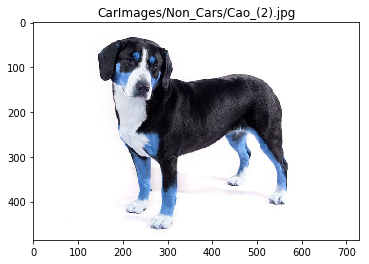

VGG16 Cao_(2).jpg: [[('n02107574', 'Greater_Swiss_Mountain_dog', 0.556252), ('n02108000', 'EntleBucher', 0.26224664), ('n02107908', 'Appenzeller', 0.1776539)]]
ResnetCao_(2).jpg: [[('n02107908', 'Appenzeller', 0.48175544), ('n02107574', 'Greater_Swiss_Mountain_dog', 0.32673395), ('n02108000', 'EntleBucher', 0.17523834)]]
VGG19 Cao_(2).jpg: [[('n02107574', 'Greater_Swiss_Mountain_dog', 0.6781291), ('n02108000', 'EntleBucher', 0.29889643), ('n02107908', 'Appenzeller', 0.021419944)]]
------------------
CarImages/Non_Cars/Cao_(3).jpg


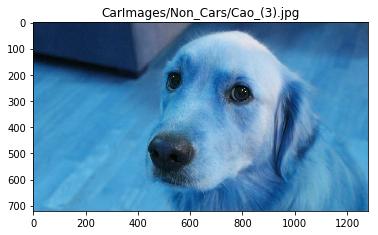

VGG16 Cao_(3).jpg: [[('n02099601', 'golden_retriever', 0.93992776), ('n02088094', 'Afghan_hound', 0.049239628), ('n02091831', 'Saluki', 0.0050706263)]]
ResnetCao_(3).jpg: [[('n02099601', 'golden_retriever', 0.9659551), ('n02099712', 'Labrador_retriever', 0.020894635), ('n02088094', 'Afghan_hound', 0.0037745251)]]
VGG19 Cao_(3).jpg: [[('n02099601', 'golden_retriever', 0.98205006), ('n02099712', 'Labrador_retriever', 0.006074876), ('n02088094', 'Afghan_hound', 0.004429136)]]
------------------
CarImages/Non_Cars/Cao_(4).jpg


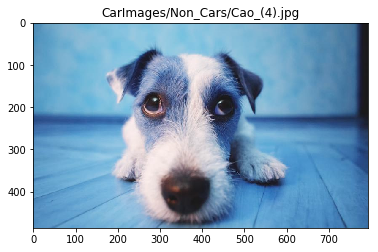

VGG16 Cao_(4).jpg: [[('n02095314', 'wire-haired_fox_terrier', 0.87899804), ('n02095570', 'Lakeland_terrier', 0.039185215), ('n02095889', 'Sealyham_terrier', 0.016544756)]]
ResnetCao_(4).jpg: [[('n02095314', 'wire-haired_fox_terrier', 0.4959091), ('n02094114', 'Norfolk_terrier', 0.07997814), ('n02095570', 'Lakeland_terrier', 0.053467035)]]
VGG19 Cao_(4).jpg: [[('n02095314', 'wire-haired_fox_terrier', 0.52947634), ('n02093991', 'Irish_terrier', 0.065555386), ('n04409515', 'tennis_ball', 0.05276926)]]
------------------
CarImages/Non_Cars/Cao_(5).jpg


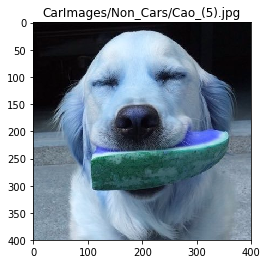

VGG16 Cao_(5).jpg: [[('n02099601', 'golden_retriever', 0.6726391), ('n02099712', 'Labrador_retriever', 0.22715114), ('n02104029', 'kuvasz', 0.041462723)]]
ResnetCao_(5).jpg: [[('n02099712', 'Labrador_retriever', 0.5091149), ('n02099601', 'golden_retriever', 0.4827435), ('n04409515', 'tennis_ball', 0.0015059515)]]
VGG19 Cao_(5).jpg: [[('n02099601', 'golden_retriever', 0.6541794), ('n02099712', 'Labrador_retriever', 0.2892554), ('n02100735', 'English_setter', 0.013285714)]]
------------------
CarImages/Non_Cars/Embarcacao_ (1).jpg


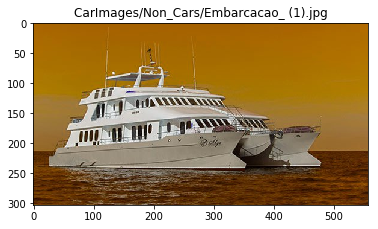

VGG16 Embarcacao_ (1).jpg: [[('n03673027', 'liner', 0.78044736), ('n02981792', 'catamaran', 0.074128814), ('n03216828', 'dock', 0.047696304)]]
ResnetEmbarcacao_ (1).jpg: [[('n03673027', 'liner', 0.51228255), ('n03216828', 'dock', 0.18162642), ('n02981792', 'catamaran', 0.1715871)]]
VGG19 Embarcacao_ (1).jpg: [[('n03673027', 'liner', 0.87923104), ('n02981792', 'catamaran', 0.046432562), ('n03216828', 'dock', 0.044562973)]]
------------------
CarImages/Non_Cars/Embarcacao_ (2).jpg


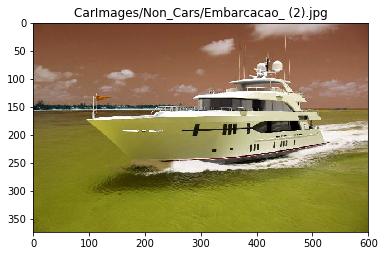

VGG16 Embarcacao_ (2).jpg: [[('n02981792', 'catamaran', 0.44062755), ('n03673027', 'liner', 0.15351358), ('n03095699', 'container_ship', 0.13843253)]]
ResnetEmbarcacao_ (2).jpg: [[('n03216828', 'dock', 0.3956158), ('n02981792', 'catamaran', 0.391235), ('n03673027', 'liner', 0.07808501)]]
VGG19 Embarcacao_ (2).jpg: [[('n02981792', 'catamaran', 0.7385357), ('n03673027', 'liner', 0.093187846), ('n03216828', 'dock', 0.0461378)]]
------------------
CarImages/Non_Cars/Embarcacao_ (3).jpg


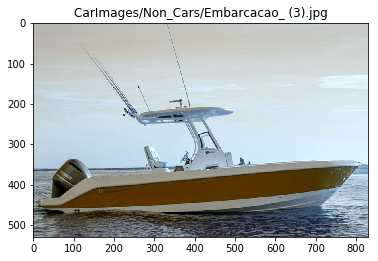

VGG16 Embarcacao_ (3).jpg: [[('n02981792', 'catamaran', 0.24763398), ('n04483307', 'trimaran', 0.24247265), ('n04606251', 'wreck', 0.1177519)]]
ResnetEmbarcacao_ (3).jpg: [[('n04483307', 'trimaran', 0.21474278), ('n03673027', 'liner', 0.15065832), ('n03344393', 'fireboat', 0.14068705)]]
VGG19 Embarcacao_ (3).jpg: [[('n02981792', 'catamaran', 0.47271928), ('n04483307', 'trimaran', 0.40084514), ('n04273569', 'speedboat', 0.027491562)]]
------------------
CarImages/Non_Cars/Embarcacao_ (4).JPG


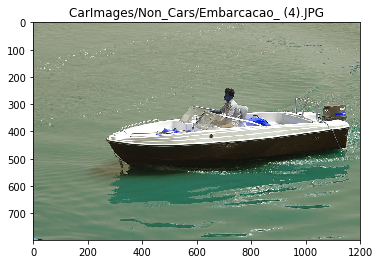

VGG16 Embarcacao_ (4).JPG: [[('n04273569', 'speedboat', 0.71067905), ('n03344393', 'fireboat', 0.16916415), ('n03095699', 'container_ship', 0.023132926)]]
ResnetEmbarcacao_ (4).JPG: [[('n04273569', 'speedboat', 0.4774393), ('n09332890', 'lakeside', 0.15496668), ('n03344393', 'fireboat', 0.15272048)]]
VGG19 Embarcacao_ (4).JPG: [[('n04273569', 'speedboat', 0.86562103), ('n02951358', 'canoe', 0.056830317), ('n03873416', 'paddle', 0.034180515)]]
------------------
CarImages/Non_Cars/Embarcacao_ (5).jpg


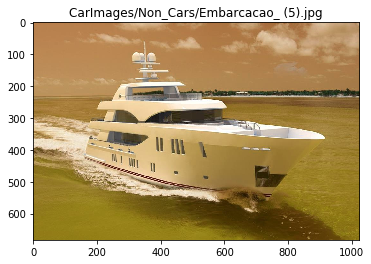

VGG16 Embarcacao_ (5).jpg: [[('n02981792', 'catamaran', 0.78285533), ('n02894605', 'breakwater', 0.05360897), ('n03673027', 'liner', 0.04712769)]]
ResnetEmbarcacao_ (5).jpg: [[('n03673027', 'liner', 0.21176511), ('n02981792', 'catamaran', 0.18743573), ('n03216828', 'dock', 0.18214983)]]
VGG19 Embarcacao_ (5).jpg: [[('n02981792', 'catamaran', 0.7166723), ('n02894605', 'breakwater', 0.051096946), ('n04347754', 'submarine', 0.04042344)]]
------------------
CarImages/Non_Cars/Embarcacao_ (6).jpg


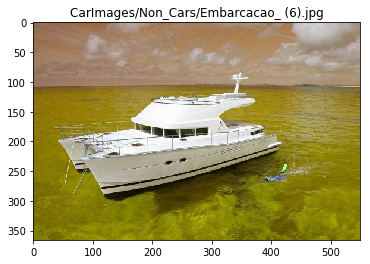

VGG16 Embarcacao_ (6).jpg: [[('n02981792', 'catamaran', 0.8529538), ('n03673027', 'liner', 0.09373034), ('n03216828', 'dock', 0.015665034)]]
ResnetEmbarcacao_ (6).jpg: [[('n03673027', 'liner', 0.9258869), ('n02981792', 'catamaran', 0.07192473), ('n03216828', 'dock', 0.0006735704)]]
VGG19 Embarcacao_ (6).jpg: [[('n02981792', 'catamaran', 0.95245355), ('n03673027', 'liner', 0.03312512), ('n04483307', 'trimaran', 0.005379228)]]
------------------
CarImages/Non_Cars/Embarcacao_ (7).jpg


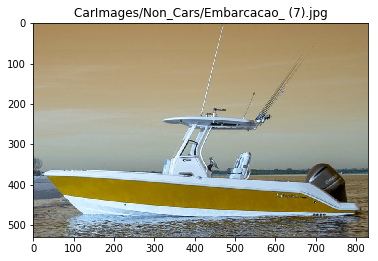

VGG16 Embarcacao_ (7).jpg: [[('n02981792', 'catamaran', 0.37171236), ('n04483307', 'trimaran', 0.26272973), ('n04606251', 'wreck', 0.110266365)]]
ResnetEmbarcacao_ (7).jpg: [[('n03344393', 'fireboat', 0.19343418), ('n03216828', 'dock', 0.15683536), ('n03673027', 'liner', 0.1091038)]]
VGG19 Embarcacao_ (7).jpg: [[('n04483307', 'trimaran', 0.3984153), ('n02981792', 'catamaran', 0.25617522), ('n04347754', 'submarine', 0.067175604)]]
------------------
CarImages/Non_Cars/Moto_ (1).jpg


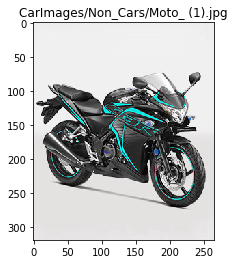

VGG16 Moto_ (1).jpg: [[('n03127747', 'crash_helmet', 0.6785013), ('n03791053', 'motor_scooter', 0.144005), ('n03785016', 'moped', 0.080157965)]]
ResnetMoto_ (1).jpg: [[('n03127747', 'crash_helmet', 0.9112219), ('n03208938', 'disk_brake', 0.015216294), ('n03792782', 'mountain_bike', 0.0146972975)]]
VGG19 Moto_ (1).jpg: [[('n03791053', 'motor_scooter', 0.34117594), ('n03785016', 'moped', 0.22568339), ('n03127747', 'crash_helmet', 0.20378608)]]
------------------
CarImages/Non_Cars/Moto_ (2).jpg


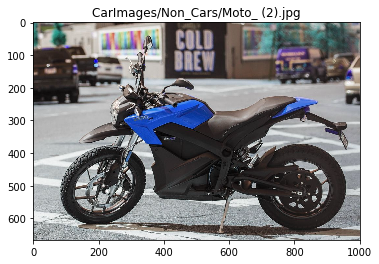

VGG16 Moto_ (2).jpg: [[('n03785016', 'moped', 0.7430667), ('n03791053', 'motor_scooter', 0.1687051), ('n03127747', 'crash_helmet', 0.04409262)]]
ResnetMoto_ (2).jpg: [[('n03127747', 'crash_helmet', 0.42592642), ('n03785016', 'moped', 0.18790738), ('n03791053', 'motor_scooter', 0.18104461)]]
VGG19 Moto_ (2).jpg: [[('n03785016', 'moped', 0.67501915), ('n03791053', 'motor_scooter', 0.18792753), ('n04482393', 'tricycle', 0.05531101)]]
------------------
CarImages/Non_Cars/Moto_ (3).jpg


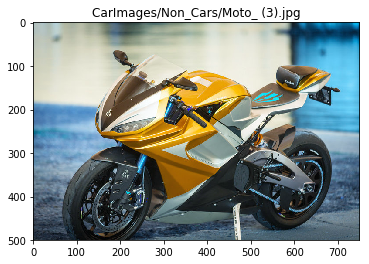

VGG16 Moto_ (3).jpg: [[('n03127747', 'crash_helmet', 0.51237607), ('n03791053', 'motor_scooter', 0.29169315), ('n03785016', 'moped', 0.17838465)]]
ResnetMoto_ (3).jpg: [[('n03127747', 'crash_helmet', 0.53941697), ('n03791053', 'motor_scooter', 0.2903231), ('n03785016', 'moped', 0.121924564)]]
VGG19 Moto_ (3).jpg: [[('n03127747', 'crash_helmet', 0.47092602), ('n03791053', 'motor_scooter', 0.36859316), ('n03785016', 'moped', 0.115286805)]]
------------------
CarImages/Non_Cars/Pessoa_ (1).jpg


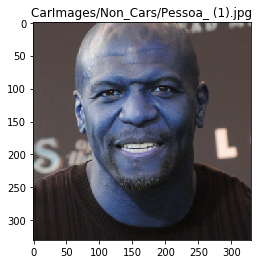

VGG16 Pessoa_ (1).jpg: [[('n03595614', 'jersey', 0.26689312), ('n03942813', 'ping-pong_ball', 0.15482987), ('n04039381', 'racket', 0.08305545)]]
ResnetPessoa_ (1).jpg: [[('n02992529', 'cellular_telephone', 0.20712152), ('n03595614', 'jersey', 0.11235943), ('n02823750', 'beer_glass', 0.034635402)]]
VGG19 Pessoa_ (1).jpg: [[('n03595614', 'jersey', 0.17774197), ('n03942813', 'ping-pong_ball', 0.0923265), ('n04039381', 'racket', 0.04540534)]]
------------------
CarImages/Non_Cars/Pessoa_ (2).jpg


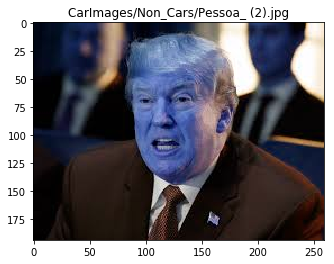

VGG16 Pessoa_ (2).jpg: [[('n04350905', 'suit', 0.29410037), ('n04591157', 'Windsor_tie', 0.09358237), ('n04584207', 'wig', 0.07109787)]]
ResnetPessoa_ (2).jpg: [[('n04591157', 'Windsor_tie', 0.3365163), ('n04350905', 'suit', 0.21133755), ('n04005630', 'prison', 0.028518505)]]
VGG19 Pessoa_ (2).jpg: [[('n04350905', 'suit', 0.09839746), ('n10148035', 'groom', 0.0637621), ('n04584207', 'wig', 0.060021292)]]
------------------
CarImages/Non_Cars/Pessoa_ (3).jpg


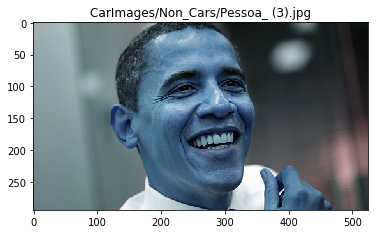

VGG16 Pessoa_ (3).jpg: [[('n04591157', 'Windsor_tie', 0.26903322), ('n03630383', 'lab_coat', 0.18546066), ('n04350905', 'suit', 0.15022744)]]
ResnetPessoa_ (3).jpg: [[('n02883205', 'bow_tie', 0.19626507), ('n04591157', 'Windsor_tie', 0.1217937), ('n03630383', 'lab_coat', 0.0971463)]]
VGG19 Pessoa_ (3).jpg: [[('n03630383', 'lab_coat', 0.22929993), ('n04591157', 'Windsor_tie', 0.085423626), ('n02883205', 'bow_tie', 0.05409324)]]
------------------


In [16]:
for eachNonCar in nonCarsImageList:
    image_path = 'CarImages/Non_Cars/{}'.format(eachNonCar)
    print (image_path)
    image = prepare_image(image_path)
    
    imageView = cv2.imread(image_path)

    plt.imshow(imageView)
    plt.title(image_path)
    plt.show()
    
    predictions = vgg16.predict(image)
    print('VGG16 {}: {}'.format(eachNonCar,get_predictions(predictions, top=3)))
    predictions = resnet50.predict(image)
    print('Resnet{}: {}'.format(eachNonCar,get_predictions(predictions, top=3)))
    predictions = vgg19.predict(image)
    print('VGG19 {}: {}'.format(eachNonCar,get_predictions(predictions, top=3)))
    print('------------------')